Mestrado em Modelagem Matematica da Informacao
----------------------------------------------
Disciplina: Modelagem e Mineracao de Dados
------------------------------------------

Master Program - Mathematical Modeling of Information
-----------------------------------------------------
Course: Data Mining and Modeling
--------------------------------

Professor: Renato Rocha Souza
-----------------------------

### Topic: Clustering documents

This notebook is based on the following sources:  
https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/  
http://www.brandonrose.org and http://www.brandonrose.org/top100  

In [1]:
import re
import os
import codecs
import string
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import feature_extraction
import mpld3
import pyLDAvis
import pyLDAvis.gensim
from IPython.display import Image

%matplotlib inline
#%matplotlib notebook

/usr/local/lib/python3.5/dist-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/usr/local/lib/python3.5/dist-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/usr/local/lib/python3.5/dist-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/usr/local/lib/python3.5/dist-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/usr/local/lib/python3.5/dist-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/usr/local/lib/python3.5/dist-packages/funcy/decorators.py:56: DeprecationW

### Introduction

Analytics Industry is all about obtaining the “Information” from the data. With the growing amount of data in recent years, that too mostly unstructured, it’s difficult to obtain the relevant and desired information. But, technology has developed some powerful methods which can be used to mine through the data and fetch the information that we are looking for.  

One such technique in the field of text mining is Topic Modelling. As the name suggests, it is a process to automatically identify topics present in a text object and to derive hidden patterns exhibited by a text corpus. Thus, assisting better decision making.  

Topic Modelling is different from rule-based text mining approaches that use regular expressions or dictionary based keyword searching techniques. It is an unsupervised approach used for finding and observing the bunch of words (called “topics”) in large clusters of texts.  

Topics can be defined as “a repeating pattern of co-occurring terms in a corpus”. A good topic model should result in – “health”, “doctor”, “patient”, “hospital” for a topic – Healthcare, and “farm”, “crops”, “wheat” for a topic – “Farming”.  

Topic Models are very useful for the purpose for document clustering, organizing large blocks of textual data, information retrieval from unstructured text and feature selection. For Example – New York Times are using topic models to boost their user – article recommendation engines. Various professionals are using topic models for recruitment industries where they aim to extract latent features of job descriptions and map them to right candidates. They are being used to organize large datasets of emails, customer reviews, and user social media profiles.  

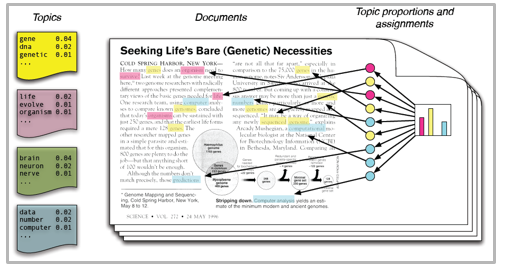

In [2]:
#Image(url='https://www.analyticsvidhya.com/wp-content/uploads/2016/08/Modeling1.png')
Image(filename='../slides/Modeling1.png')

### Latent Dirichlet Allocation for Topic Modeling  

There are many approaches for obtaining topics from a text such as – Term Frequency and Inverse Document Frequency. NonNegative Matrix Factorization techniques. Latent Dirichlet Allocation is the most popular topic modeling technique and in this article, we will discuss the same.  

LDA assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution. Given a dataset of documents, LDA backtracks and tries to figure out what topics would create those documents in the first place.  

LDA is a matrix factorization technique. In vector space, any corpus (collection of documents) can be represented as a document-term matrix. The following matrix shows a corpus of N documents D1, D2, D3 … Dn and vocabulary size of M words W1,W2 .. Wn. The value of i,j cell gives the frequency count of word Wj in Document Di.  

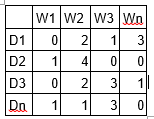

In [3]:
#Image(url='https://www.analyticsvidhya.com/wp-content/uploads/2016/08/Modeling2.png')
Image(filename='../slides/Modeling2.png')

LDA converts this Document-Term Matrix into two lower dimensional matrices – M1 and M2.
M1 is a document-topics matrix and M2 is a topic – terms matrix with dimensions (N,  K) and (K, M) respectively, where N is the number of documents, K is the number of topics and M is the vocabulary size.  

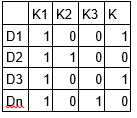

In [4]:
Image(filename='../slides/modeling3.png')

Notice that these two matrices already provides topic word and document topic distributions, However, these distribution needs to be improved, which is the main aim of LDA. LDA makes use of sampling techniques in order to improve these matrices.  

It Iterates through each word “w” for each document “d” and tries to adjust the current topic – word assignment with a new assignment. A new topic “k” is assigned to word “w” with a probability P which is a product of two probabilities p1 and p2.  

For every topic, two probabilities p1 and p2 are calculated. P1 – p(topic t / document d) = the proportion of words in document d that are currently assigned to topic t. P2 – p(word w / topic t) = the proportion of assignments to topic t over all documents that come from this word w.  

The current topic – word assignment is updated with a new topic with the probability, product of p1 and p2 . In this step, the model assumes that all the existing word – topic assignments except the current word are correct. This is essentially the probability that topic t generated word w, so it makes sense to adjust the current word’s topic with new probability.  

After a number of iterations, a steady state is achieved where the document topic and topic term distributions are fairly good. This is the convergence point of LDA.  

 
#### Parameters of LDA  

Alpha and Beta Hyperparameters – alpha represents document-topic density and Beta represents topic-word density. Higher the value of alpha, documents are composed of more topics and lower the value of alpha, documents contain fewer topics. On the other hand, higher the beta, topics are composed of a large number of words in the corpus, and with the lower value of beta, they are composed of few words.  

Number of Topics – Number of topics to be extracted from the corpus. Researchers have developed approaches to obtain an optimal number of topics by using Kullback Leibler Divergence Score. I will not discuss this in detail, as it is too mathematical. For understanding, one can refer to this[1] original paper on the use of KL divergence.  

Number of Topic Terms – Number of terms composed in a single topic. It is generally decided according to the requirement. If the problem statement talks about extracting themes or concepts, it is recommended to choose a higher number, if problem statement talks about extracting features or terms, a low number is recommended.  

Number of Iterations / passes – Maximum number of iterations allowed to LDA algorithm for convergence.  

In [5]:
# Here are the sample documents combining together to form a corpus.

doc1 = "Sugar is bad to consume. My sister likes to have sugar, but not my father."
doc2 = "My father spends a lot of time driving my sister around to dance practice."
doc3 = "Doctors suggest that driving may cause increased stress and blood pressure."
doc4 = "Sometimes I feel pressure to perform well at school, but my father never seems to drive my sister to do better."
doc5 = "Health experts say that Sugar is not good for your lifestyle."

# compile documents
doc_complete = [doc1, doc2, doc3, doc4, doc5]

#### Cleaning and Preprocessing

Cleaning is an important step before any text mining task, in this step, we will remove the punctuations, stopwords and normalize the corpus.  

In [6]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in doc_complete]   

#### Preparing Document-Term Matrix

All the text documents combined is known as the corpus. To run any mathematical model on text corpus, it is a good practice to convert it into a matrix representation. LDA model looks for repeating term patterns in the entire DT matrix. Python provides many great libraries for text mining practices, “gensim” is one such clean and beautiful library to handle text data. It is scalable, robust and efficient. Following code shows how to convert a corpus into a document-term matrix.  

In [7]:
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

/usr/local/lib/python3.5/dist-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


#### Running LDA Model  

Next step is to create an object for LDA model and train it on Document-Term matrix. The training also requires few parameters as input which are explained in the above section. The gensim module allows both LDA model estimation from a training corpus and inference of topic distribution on new, unseen documents.

In [8]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)

In [9]:
print(ldamodel.print_topics(num_topics=3, num_words=3))

[(0, '0.085*"sister" + 0.085*"father" + 0.084*"sugar"'), (1, '0.075*"expert" + 0.075*"lifestyle" + 0.075*"health"'), (2, '0.071*"pressure" + 0.041*"well" + 0.041*"feel"')]


#### Tips to improve results of topic modeling

The results of topic models are completely dependent on the features (terms) present in the corpus. The corpus is represented as document term matrix, which in general is very sparse in nature. Reducing the dimensionality of the matrix can improve the results of topic modelling. Based on my practical experience, there are few approaches which do the trick.  

1. Frequency Filter – Arrange every term according to its frequency. Terms with higher frequencies are more likely to appear in the results as compared ones with low frequency. The low frequency terms are essentially weak features of the corpus, hence it is a good practice to get rid of all those weak features. An exploratory analysis of terms and their frequency can help to decide what frequency value should be considered as the threshold.  

2. Part of Speech Tag Filter – POS tag filter is more about the context of the features than frequencies of features. Topic Modelling tries to map out the recurring patterns of terms into topics. However, every term might not be equally important contextually. For example, POS tag IN contain terms such as – “within”, “upon”, “except”. “CD” contains – “one”,”two”, “hundred” etc. “MD” contains “may”, “must” etc. These terms are the supporting words of a language and can be removed by studying their post tags.  

3. Batch Wise LDA –In order to retrieve most important topic terms, a corpus can be divided into batches of fixed sizes. Running LDA multiple times on these batches will provide different results, however, the best topic terms will be the intersection of all batches.  

#### Topic Modelling for Feature Selection

Sometimes LDA can also be used as feature selection technique. Take an example of text classification problem where the training data contain category wise documents. If LDA is running on sets of category wise documents. Followed by removing common topic terms across the results of different categories will give the best features for a category.  

### Topic Modeling applied to film synopses

In this guide, I will explain how to cluster a set of documents using Python. My motivating example is to identify the latent structures within the synopses of the top 100 films of all time (per an IMDB list). 

This notebook covers:

<ul>
<li> tokenizing and stemming each synopsis
<li> transforming the corpus into vector space using [tf-idf](http://en.wikipedia.org/wiki/Tf%E2%80%93idf)
<li> calculating cosine distance between each document as a measure of similarity
<li> clustering the documents using the [k-means algorithm](http://en.wikipedia.org/wiki/K-means_clustering)
<li> using [multidimensional scaling](http://en.wikipedia.org/wiki/Multidimensional_scaling) to reduce dimensionality within the corpus
<li> plotting the clustering output using [matplotlib](http://matplotlib.org/) and [mpld3](http://mpld3.github.io/)
<li> conducting a hierarchical clustering on the corpus using [Ward clustering](http://en.wikipedia.org/wiki/Ward%27s_method)
<li> plotting a Ward dendrogram
<li> topic modeling using [Latent Dirichlet Allocation (LDA)](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)
</ul>

## Contents

<ul>
<li>[Stopwords, stemming, and tokenization](#Stopwords,-stemming,-and-tokenizing)
<li>[Tf-idf and document similarity](#Tf-idf-and-document-similarity)
<li>[K-means clustering](#K-means-clustering)
<li>[Multidimensional scaling](#Multidimensional-scaling)
<li>[Visualizing document clusters](#Visualizing-document-clusters)
<li>[Hierarchical document clustering](#Hierarchical-document-clustering)
<li>[Latent Dirichlet Allocation (LDA)](#Latent-Dirichlet-Allocation)
</ul>

But first, I import everything I am going to need up front

Specifying the path to the files  

In [10]:
datapath = "../datasets/texts/doccluster/"
outputs = "../outputs/"

#### import three lists: titles, links and wikipedia synopses  

In [11]:
titles = open(os.path.join(datapath, 'title_list.txt')).read().split('\n')
#ensures that only the first 100 are read in
titles = titles[:100]
print(str(len(titles)) + ' titles')

print(titles[0:5])

100 titles
['The Godfather', 'The Shawshank Redemption', "Schindler's List", 'Raging Bull', 'Casablanca']


In [12]:
links = open(os.path.join(datapath, 'link_list_imdb.txt')).read().split('\n')
links = links[:100]
print(str(len(links)) + ' links')

print(links[0:5])

100 links
['http://www.imdb.com/title/tt0068646/', 'http://www.imdb.com/title/tt0111161/', 'http://www.imdb.com/title/tt0108052/', 'http://www.imdb.com/title/tt0081398/', 'http://www.imdb.com/title/tt0034583/']


In [13]:
synopses_wiki = open(os.path.join(datapath, 'synopses_list_wiki.txt')).read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_wiki.append(text)
synopses_wiki = synopses_clean_wiki

print(str(len(synopses_wiki)) + ' synopses')

print(synopses_wiki[0][0:300])

100 synopses
 Plot  [edit]  [  [  edit  edit  ]  ]  
  On the day of his only daughter's wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito's youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the spra


In [14]:
genres = open(os.path.join(datapath,'genres_list.txt')).read().split('\n')
genres = genres[:100]
print(str(len(genres)) + ' genres')

print(genres[0:5])

100 genres
["[u' Crime', u' Drama']", "[u' Crime', u' Drama']", "[u' Biography', u' Drama', u' History']", "[u' Biography', u' Drama', u' Sport']", "[u' Drama', u' Romance', u' War']"]


In [15]:
synopses_imdb = open(os.path.join(datapath,'synopses_list_imdb.txt')).read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]
synopses_clean_imdb = []

for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_imdb.append(text)

synopses_imdb = synopses_clean_imdb

In [16]:
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

In [17]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
ranks = []

for i in range(0,len(titles)):
    ranks.append(i)

### Stopwords, stemming, and tokenizing

This section is focused on defining some functions to manipulate the synopses. First, I load [NLTK's](http://www.nltk.org/) list of English stop words. [Stop words](http://en.wikipedia.org/wiki/Stop_words) are words like "a", "the", or "in" which don't convey significant meaning. I'm sure there are much better explanations of this out there.

In [18]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

Next I import the [Snowball Stemmer](http://snowball.tartarus.org/) which is actually part of NLTK. [Stemming](http://en.wikipedia.org/wiki/Stemming) is just the process of breaking a word down into its root.

In [19]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")


Below I define two functions:

<ul>
<li> *tokenize_and_stem*: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token <li> *tokenize_only*: tokenizes the synopsis only
</ul>

I use both these functions to create a dictionary which becomes important in case I want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes. Guess what, I do want to do that!



In [20]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Below I use my stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized. 

In [21]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

Using these two lists, I create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token. The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. For my purposes this is fine--I'm perfectly happy returning the first token associated with the stem I need to look up.

In [22]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

### Tf-idf and document similarity

<img src='http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402' align='right' style="margin-left:10px">

Here, I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the *synopses* list into a tf-idf matrix. 

To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. An example of a dtm is here at right.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters I define below:

<ul>
<li> max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
<li> min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
<li> ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See [n-grams](http://en.wikipedia.org/wiki/N-gram)
</ul>

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, 
                                   max_features=200000,
                                   min_df=0.2, 
                                   stop_words='english',
                                   use_idf=True, 
                                   tokenizer=tokenize_and_stem, 
                                   ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_matrix.shape)

CPU times: user 12.3 s, sys: 164 ms, total: 12.5 s
Wall time: 12.5 s
(100, 563)


In [24]:
terms = tfidf_vectorizer.get_feature_names()

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

### K-means clustering

Now onto the fun part. Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose [k-means](http://en.wikipedia.org/wiki/K-means_clustering). K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and  centroids recalculated in an iterative process until the algorithm reaches convergence.

I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima. 

In [26]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 652 ms, sys: 0 ns, total: 652 ms
Wall time: 654 ms


In [27]:
from sklearn.externals import joblib

joblib.dump(km, os.path.join(outputs, 'doc_cluster.pkl'))
km = joblib.load(os.path.join(outputs, 'doc_cluster.pkl'))
clusters = km.labels_.tolist()

In [28]:
films = {'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres}
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

In [29]:
frame.head()

,rank,title,cluster,genre
2,0,The Godfather,2,"[u' Crime', u' Drama']"
1,1,The Shawshank Redemption,1,"[u' Crime', u' Drama']"
2,2,Schindler's List,2,"[u' Biography', u' Drama', u' History']"
2,3,Raging Bull,2,"[u' Biography', u' Drama', u' Sport']"
0,4,Casablanca,0,"[u' Drama', u' Romance', u' War']"


In [30]:
frame['cluster'].value_counts()

1    39
2    28
4    19
0     8
3     6
Name: cluster, dtype: int64

In [31]:
grouped = frame['rank'].groupby(frame['cluster'])

grouped.mean()

cluster
0    55.875000
1    51.128205
2    48.678571
3    52.833333
4    43.631579
Name: rank, dtype: float64

In [32]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: b'sister', b'marriage', b'house', b'war', b'home', b'world',

Cluster 0 titles: Casablanca, A Streetcar Named Desire, The Best Years of Our Lives, Ben-Hur, Mr. Smith Goes to Washington, Out of Africa, Good Will Hunting, Yankee Doodle Dandy,

Cluster 1 words: b'police', b'car', b'house', b'killed', b'asks', b'home',

Cluster 1 titles: The Shawshank Redemption, One Flew Over the Cuckoo's Nest, The Wizard of Oz, Titanic, Psycho, Sunset Blvd., Vertigo, Forrest Gump, West Side Story, E.T. the Extra-Terrestrial, 2001: A Space Odyssey, The Silence of the Lambs, Chinatown, Singin' in the Rain, Some Like It Hot, 12 Angry Men, Gandhi, Rocky, My Fair Lady, Jaws, The Apartment, The Exorcist, The Deer Hunter, The French Connection, Fargo, The Green Mile, Close Encounters of the Third Kind, Nashville, The Graduate, American Graffiti, Pulp Fiction, The Maltese Falcon, A Clockwork Orange, Wuthering Heights, Double Indemnity, Rebel Without a Cause, Rear Window, 

In [33]:
#This is purely to help export tables to html and to correct for my 0 start rank (so that Godfather is 1, not 0)
frame['Rank'] = frame['rank'] + 1
frame['Title'] = frame['title']

In [34]:
#export tables to HTML
html_output = frame[['Rank', 'Title']].loc[frame['cluster'] == 1].to_html(index=False)

from IPython.core.display import display, HTML
display(HTML(html_output))

Rank,Title
2,The Shawshank Redemption
6,One Flew Over the Cuckoo's Nest
9,The Wizard of Oz
10,Titanic
13,Psycho
14,Sunset Blvd.
15,Vertigo
17,Forrest Gump
19,West Side Story
21,E.T. the Extra-Terrestrial


### Multidimensional scaling

In [35]:
from sklearn.manifold import MDS

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [36]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

### Visualizing document clusters

In [37]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

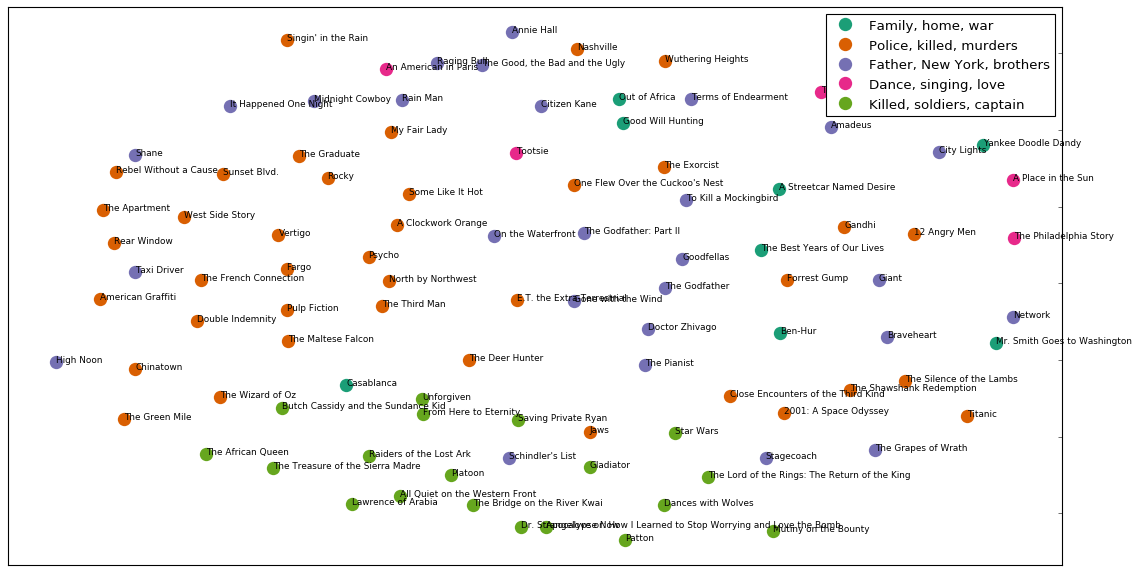

In [38]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

plt.show()

#Saving the Fig
plt.savefig(os.path.join(outputs,'clusters_small_noaxes.png'), dpi=200)

The clustering plot looks great, but it would be better without overlapping labels. We are going to use D3.js (http://d3js.org/), a browser based/javascript interactive. We will use a matplotlib D3 wrapper called mpld3 (https://mpld3.github.io/). Mpld3 basically let's you use matplotlib syntax to create web interactives. It has a really easy, high-level API for adding tooltips on mouse hover, which is what I am interested in.

It also has some nice functionality for zooming and panning. The below javascript snippet basicaly defines a custom location for where the zoom/pan toggle resides. Don't worry about it too much and you actually don't need to use it, but it helped for formatting purposes when exporting to the web later. The only thing you might want to change is the x and y attr for the position of the toolbar.

In [39]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [40]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, label=cluster_names[name], mec='none', color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

In [41]:
#uncomment the below to export to html
#os.chdir(outputs)
#html = mpld3.fig_to_html(fig)
#print(html)

### Hierarchical document clustering

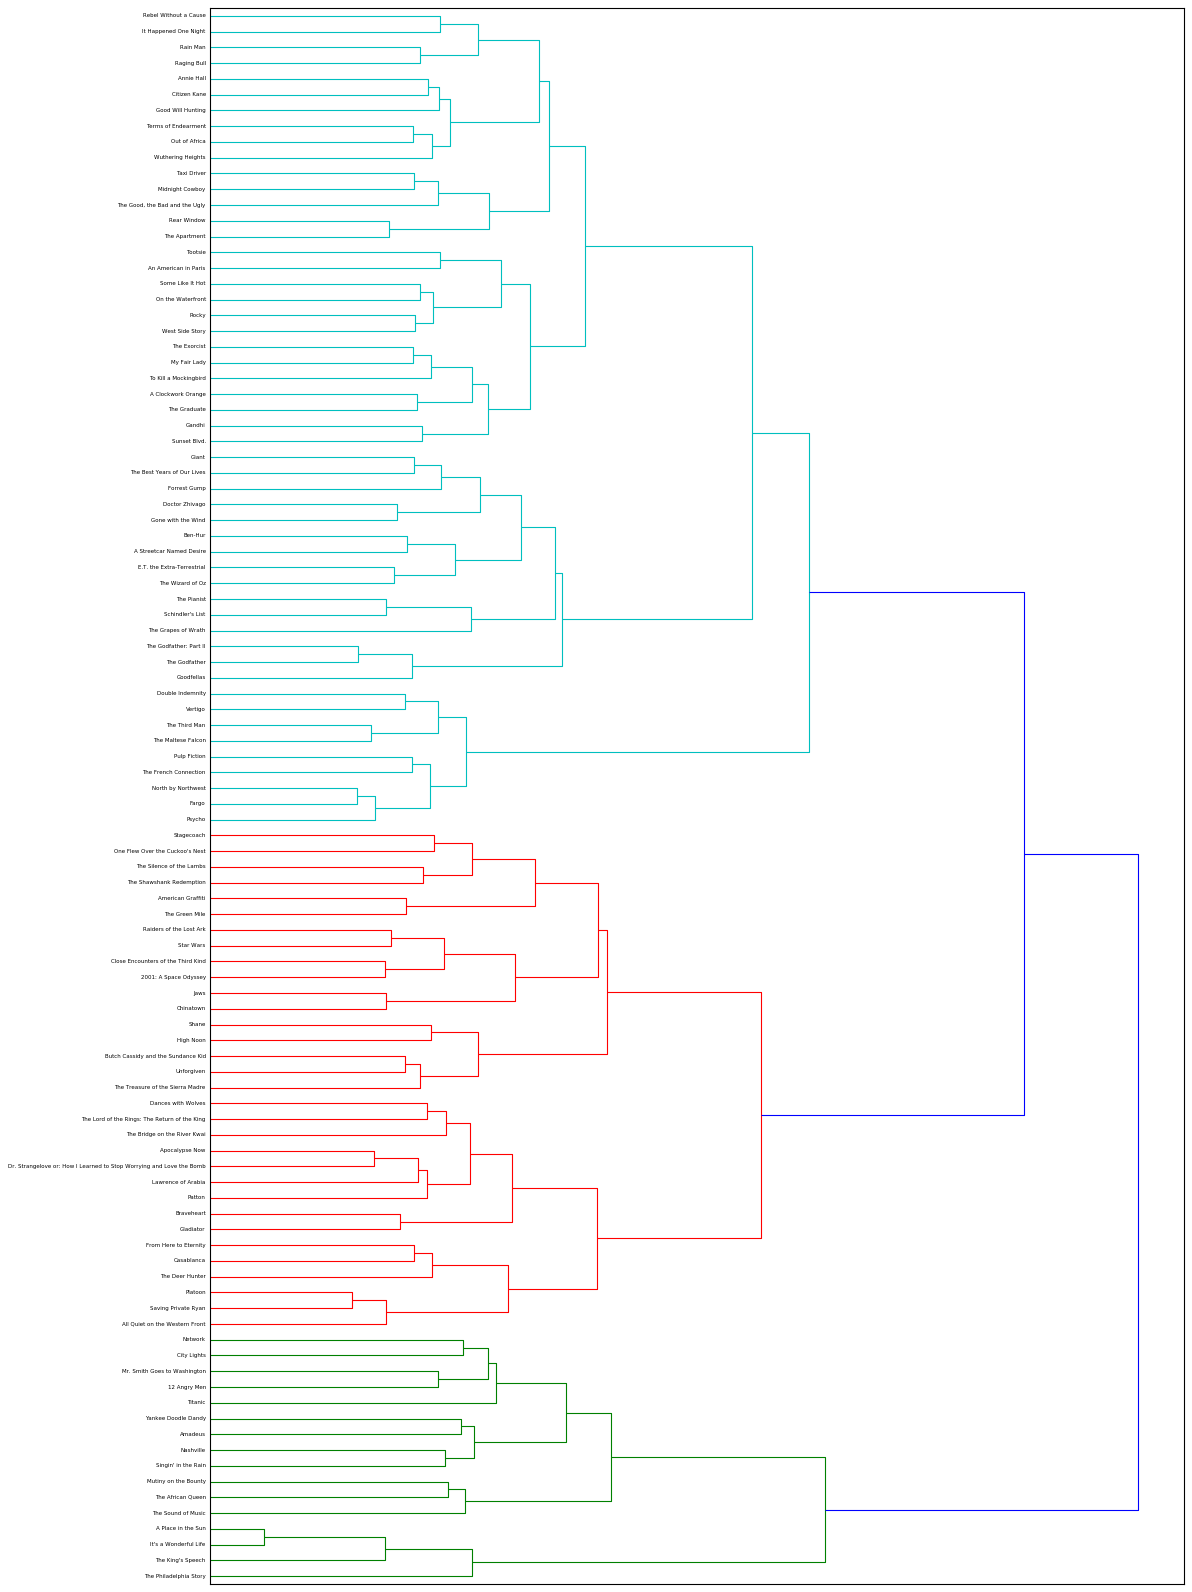

In [42]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout
plt.savefig(os.path.join(outputs,'ward_clusters.png'), dpi=200)

### Latent Dirichlet Allocation

In [43]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [44]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [45]:
#Latent Dirichlet Allocation implementation with Gensim
from gensim import corpora, models, similarities 

#remove proper names
preprocess = [strip_proppers(doc) for doc in synopses]

%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

CPU times: user 4.96 s, sys: 4 ms, total: 4.97 s
Wall time: 4.97 s
CPU times: user 432 ms, sys: 0 ns, total: 432 ms
Wall time: 433 ms


In [46]:
#print(len([word for word in texts[0] if word not in stopwords]))
print(len(texts[0]))

1839


In [47]:
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=1, no_above=0.8)
corpus = [dictionary.doc2bow(text) for text in texts]

In [48]:
len(corpus)

100

In [49]:
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

CPU times: user 7min, sys: 640 ms, total: 7min
Wall time: 7min


In [50]:
print(lda[corpus[0]])

[(1, 0.26952821772365454), (4, 0.73010015633330816)]


In [51]:
topics = lda.print_topics(5, num_words=20)

In [52]:
lda.show_topics()

[(0,
  '0.009*"kill" + 0.006*"order" + 0.006*"men" + 0.004*"son" + 0.004*"soldier" + 0.004*"two" + 0.004*"execut" + 0.003*"night" + 0.003*"say" + 0.003*"war"'),
 (1,
  '0.005*"car" + 0.005*"go" + 0.005*"n\'t" + 0.004*"night" + 0.004*"call" + 0.004*"ask" + 0.004*"day" + 0.004*"two" + 0.004*"friend" + 0.004*"doe"'),
 (2,
  '0.007*"shark" + 0.006*"kill" + 0.005*"water" + 0.005*"ship" + 0.005*"men" + 0.005*"boat" + 0.005*"soldier" + 0.004*"two" + 0.004*"offic" + 0.004*"fire"'),
 (3,
  '0.007*"polic" + 0.005*"father" + 0.005*"arriv" + 0.005*"ask" + 0.005*"home" + 0.005*"meet" + 0.004*"say" + 0.004*"friend" + 0.004*"car" + 0.004*"kill"'),
 (4,
  '0.008*"famili" + 0.006*"kill" + 0.005*"arriv" + 0.004*"friend" + 0.004*"attempt" + 0.004*"home" + 0.004*"say" + 0.003*"know" + 0.003*"order" + 0.003*"life"')]

In [53]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)

In [54]:
topics_matrix[0]

(0,
 [('kill', 0.0086340762579549639),
  ('order', 0.0058805291327592938),
  ('men', 0.0057763134304052773),
  ('son', 0.0038343635186422189),
  ('soldier', 0.0037897320489788991),
  ('two', 0.0036195173265344527),
  ('execut', 0.0035741569491318662),
  ('night', 0.00333857286834423),
  ('say', 0.0031929190343653602),
  ('war', 0.0030846170953625083),
  ('meet', 0.0030669564733853969),
  ('also', 0.0030479743714387107),
  ('command', 0.0030200503625321473),
  ('becom', 0.0029877662004678062),
  ('ask', 0.0029642866965170506),
  ('death', 0.0029142054223266949),
  ('would', 0.0027923388913687545),
  ('wife', 0.0027887328128645751),
  ('fight', 0.002785404391705082),
  ('offic', 0.0026723519582540459)])

In [55]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      36.949669        1       1  0.064548  0.005169
4      22.344957        1       2  0.017702 -0.007682
3      14.191767        1       3  0.075991  0.025377
0      13.474253        1       4 -0.057524 -0.102534
2      13.039354        1       5 -0.100717  0.079670, topic_info=     Category        Freq       Term       Total  loglift  logprob
term                                                              
1795  Default  108.000000      shark  108.000000  30.0000  30.0000
7999  Default  256.000000      polic  256.000000  29.0000  29.0000
2385  Default  197.000000    soldier  197.000000  28.0000  28.0000
2682  Default  306.000000        car  306.000000  27.0000  27.0000
4513  Default  345.000000     famili  345.000000  26.0000  26.0000
6083  Default  590.000000       kill  590.000000  25.0000  25.0000
2732  Default  316.000000        men  316.000000  24.0000  24.0000
1534  Default  139.000000      water  139.000000  23.0000  23.0000
1895  Default  111.000000       boat  111.000000  22.0000  22.0000
4130  Default  132.000000       ship  132.000000  21.0000  21.0000
1470  Default  295.000000      order  295.000000  20.0000  20.0000
7845  Default   61.000000      bridg   61.000000  19.0000  19.0000
6153  Default  148.000000        war  148.000000  18.0000  18.0000
4670  Default   62.000000    mission   62.000000  17.0000  17.0000
7542  Default  127.000000    command  127.000000  16.0000  16.0000
3090  Default   98.000000     execut   98.000000  15.0000  15.0000
1739  Default  207.000000      apart  207.000000  14.0000  14.0000
2148  Default  316.000000     father  316.000000  13.0000  13.0000
1597  Default   47.000000      beach   47.000000  12.0000  12.0000
6367  Default   79.000000     villag   79.000000  11.0000  11.0000
4460  Default  167.000000        son  167.000000  10.0000  10.0000
4425  Default  376.000000      arriv  376.000000   9.0000   9.0000
1852  Default   84.000000    destroy   84.000000   8.0000   8.0000
2151  Default  160.000000       fire  160.000000   7.0000   7.0000
3487  Default  161.000000     prison  161.000000   6.0000   6.0000
2180  Default   54.000000      river   54.000000   5.0000   5.0000
4856  Default   38.000000      squad   38.000000   4.0000   4.0000
3840  Default  238.000000       film  238.000000   3.0000   3.0000
3815  Default   34.000000        pod   34.000000   2.0000   2.0000
4442  Default   38.000000       king   38.000000   1.0000   1.0000
...       ...         ...        ...         ...      ...      ...
3654   Topic5   23.362027       sink   31.128825   1.7502  -6.4825
1534   Topic5   80.669091      water  139.846500   1.4870  -5.2433
5110   Topic5   29.679200    captain   42.186697   1.6855  -6.2432
2331   Topic5   35.357636       unit   52.811414   1.6360  -6.0681
6367   Topic5   47.147183     villag   79.292599   1.5173  -5.7804
1852   Topic5   42.267070    destroy   84.979749   1.3388  -5.8896
2385   Topic5   71.987686    soldier  197.116029   1.0299  -5.3572
8077   Topic5   15.624663      rapid   20.871222   1.7477  -6.8848
1      Topic5   13.808168  astronaut   17.444780   1.8034  -7.0084
2151   Topic5   55.663755       fire  160.707159   0.9769  -5.6143
1655   Topic5   24.519387       tank   44.087379   1.4505  -6.4342
2732   Topic5   80.223675        men  316.905417   0.6634  -5.2488
6448   Topic5   45.569831      three  124.597604   1.0314  -5.8144
641    Topic5   24.307739   militari   45.716861   1.4055  -6.4429
6083   Topic5   93.418761       kill  590.353272   0.1936  -5.0966
6637   Topic5   56.080390      offic  267.255845   0.4758  -5.6069
3550   Topic5   50.445393        use  222.810141   0.5518  -5.7128
6027   Topic5   60.326452        two  391.645201   0.1666  -5.5339
490    Topic5   46.691883       plan  216.499790   0.5032  -5.7901
5796   Topic5   43.685100        set  187.216985   0.5819  -5.8566
1470   Topic5   51.190618   